# CS611 Machine Learning Engineering - Assignment 1

## Import Libraries

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col, count, when, isnan
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, NumericType

import utils.data_processing_bronze_table
import utils.data_processing_silver_loan_daily
import utils.data_processing_silver_attributes
import utils.data_processing_silver_clickstream
import utils.data_processing_silver_financials
import utils.data_processing_gold_table

## Set Up PySpark Session

In [2]:
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/22 07:54:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Set Up Config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Bronze Level Processing

In [5]:
# create bronze datalake
bronze_output_directory = "datamart/bronze/"

if not os.path.exists(bronze_output_directory):
    os.makedirs(bronze_output_directory)

In [6]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_output_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/loan_daily/bronze_loan_daily_2023_01_01.csv
2023-01-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_2023_01_01.csv
2023-01-01row count: 530
saved to: datamart/bronze/attributes/bronze_attributes_2023_01_01.csv
2023-01-01row count: 530
saved to: datamart/bronze/financials/bronze_financials_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart/bronze/loan_daily/bronze_loan_daily_2023_02_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_2023_02_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/attributes/bronze_attributes_2023_02_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/financials/bronze_financials_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart/bronze/loan_daily/bronze_loan_daily_2023_03_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_2023_03_01.csv
2023-03-01row count: 506
saved to: data

In [7]:
# inspect output
utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_output_directory, spark).toPandas()

2024-12-01row count: 5531
saved to: datamart/bronze/loan_daily/bronze_loan_daily_2024_12_01.csv
2024-12-01row count: 8974
saved to: datamart/bronze/clickstream/bronze_clickstream_2024_12_01.csv
2024-12-01row count: 515
saved to: datamart/bronze/attributes/bronze_attributes_2024_12_01.csv
2024-12-01row count: 515
saved to: datamart/bronze/financials/bronze_financials_2024_12_01.csv


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x103e,98690.8,8262.233333,4,6,9,1_,Student Loan,6,17,...,Good,706.96,26.860663,26 Years and 11 Months,No,55.004408,913.4813186573292,Low_spent_Small_value_payments,147.7376071067124,2024-12-01
1,CUS_0x1195,30429.91,2808.825833,4,6,16,2,"Auto Loan, and Auto Loan",22,17,...,Standard,362.48,33.349050,28 Years and 11 Months,No,29.914076,82.87878577514347,Low_spent_Large_value_payments,438.08972109416084,2024-12-01
2,CUS_0x1197,92300.01,7437.667500,2,4,11,3,"Credit-Builder Loan, Not Specified, and Credit...",27,9,...,_,755.17_,26.989787,18 Years and 11 Months,Yes,49236.000000,220.8621525417414,Low_spent_Large_value_payments,581.1567885447394,2024-12-01
3,CUS_0x11e2,44986.55,3689.879167,6,5,11,1,Credit-Builder Loan,0,4,...,Good,753.21,25.586286,20 Years and 0 Months,No,23.267135,43.20363344633164,High_spent_Large_value_payments,542.5171477430948,2024-12-01
4,CUS_0x11ec,14867.69,1005.974167,9,9,18,6,"Debt Consolidation Loan, Student Loan, Persona...",39,15,...,Standard,2344.06,24.344388,17 Years and 2 Months,Yes,55.459604,100.14574834721886,Low_spent_Medium_value_payments,224.99206407779144,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0xe6c,125597.52,9367.500187,1,3,12,4,"Debt Consolidation Loan, Not Specified, Studen...",2,9,...,Good,1294.94,30.324257,30 Years and 5 Months,NM,1278.186251,964.5381161830327,Low_spent_Medium_value_payments,763.3982127892344,2024-12-01
511,CUS_0xe99,45461.54,3917.461667,6,3,5,2,"Credit-Builder Loan, and Payday Loan",20,9,...,Standard,647.24,27.264685,16 Years and 9 Months,No,69.318349,42.941001590068666,High_spent_Large_value_payments,519.4868162135749,2024-12-01
512,CUS_0xf55,78443.48_,6358.956667,7,5,23,4,"Personal Loan, Home Equity Loan, Mortgage Loan...",39,19,...,Bad,1527.77,24.704429,15 Years and 10 Months,NM,177.387563,528.7469053018515,Low_spent_Medium_value_payments,209.76119880079318,2024-12-01
513,CUS_0xfd1,78666.56999999999,6485.547500,3,4,17,4,"Not Specified, Personal Loan, Home Equity Loan...",29,10,...,Standard,1498.7,37.831762,22 Years and 5 Months,No,247.851145,252.3461368272953,High_spent_Small_value_payments,408.35746850506007,2024-12-01


## Silver Level Processing

In [8]:
# create silver datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"
silver_attributes_directory = "datamart/silver/attributes/"
silver_clickstream_directory = "datamart/silver/clickstream/"
silver_financials_directory = "datamart/silver/financials/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)
if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)
if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)
if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [9]:
bronze_lms_directory = "datamart/bronze/loan_daily/"
bronze_attributes_directory = "datamart/bronze/attributes/"
bronze_clickstream_directory = "datamart/bronze/clickstream/"
bronze_financials_directory = "datamart/bronze/financials/"

In [10]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_loan_daily.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark)
    utils.data_processing_silver_attributes.process_silver_table(date_str, bronze_attributes_directory, silver_attributes_directory, spark)
    utils.data_processing_silver_clickstream.process_silver_table(date_str, bronze_clickstream_directory, silver_clickstream_directory, spark)
    utils.data_processing_silver_financials.process_silver_table(date_str, bronze_financials_directory, silver_financials_directory, spark)


loaded from: datamart/bronze/loan_daily/bronze_loan_daily_2023_01_01.csv row count: 530
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/attributes/bronze_attributes_2023_01_01.csv row count: 530
saved to: datamart/silver/attributes/silver_attributes_2023_01_01.parquet
loaded from: datamart/bronze/clickstream/bronze_clickstream_2023_01_01.csv row count: 8974
saved to: datamart/silver/clickstream/silver_clickstream_2023_01_01.parquet
loaded from: datamart/bronze/financials/bronze_financials_2023_01_01.csv row count: 530
saved to: datamart/silver/financials/silver_financials_2023_01_01.parquet
loaded from: datamart/bronze/loan_daily/bronze_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/attributes/bronze_attributes_2023_02_01.csv row count: 501
saved to: datamart/silver/attributes/silver_attributes_2023_02_01.parquet
loaded from: datamart/

## EDA

In [11]:
silver_base_directory = "datamart/silver/"

In [12]:
# running simple checks on sample files from each folder
sample_files = {
    "attributes": "silver_attributes_2023_01_01.parquet",
    "clickstream": "silver_clickstream_2023_01_01.parquet",
    "financials": "silver_financials_2023_01_01.parquet",
    "loan_daily": "silver_loan_daily_2023_01_01.parquet"
}

for folder, file in sample_files.items():
    path = os.path.join(silver_base_directory, folder, file)
    print(f"\n=== {folder.upper()} ===\nFile: {path}")
    
    df = spark.read.parquet(path)
    df.printSchema()
    
    # summary stats
    numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
    if numeric_cols:
        df.select(numeric_cols).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()


=== ATTRIBUTES ===
File: datamart/silver/attributes/silver_attributes_2023_01_01.parquet
root
 |-- Customer_ID: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- Age: integer (nullable = true)

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               466|
|   mean|35.242489270386265|
| stddev|10.033663629662794|
|    min|                18|
|    25%|                27|
|    50%|                35|
|    75%|                43|
|    max|                56|
+-------+------------------+


=== CLICKSTREAM ===
File: datamart/silver/clickstream/silver_clickstream_2023_01_01.parquet
root
 |-- fe_1: integer (nullable = true)
 |-- fe_2: integer (nullable = true)
 |-- fe_3: integer (nullable = true)
 |-- fe_4: integer (nullable = true)
 |-- fe_5: integer (nullable = true)
 |-- fe_6: integer (nullable = true)
 |-- fe_7: integer (nullable = true)
 |-- fe_8: integer (nullable = tru

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              fe_1|              fe_2|              fe_3|              fe_4|              fe_5|              fe_6|              fe_7|              fe_8|              fe_9|             fe_10|             fe_11|             fe_12|             fe_13|             fe_14|             fe_15|             fe_16|             fe_17|             fe_18|             fe_19|             fe_20|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--

In [13]:
preview_config = {
    "loan_daily": ["Customer_ID", "loan_id", "mob", "dpd"],
    "financials": ["Customer_ID", "Annual_Income", "Num_of_Loan"],
    "attributes": ["Customer_ID", "Age", "Occupation"],
    "clickstream": ["Customer_ID", "fe_1", "fe_2"]
}

for folder, cols in preview_config.items():
    path = os.path.join(silver_base_directory, folder, "*.parquet")
    print(f"\n=== {folder.upper()} ===")
    df = spark.read.parquet(path)
    df.select(*cols).show(5, truncate=False)


=== LOAN_DAILY ===
+-----------+---------------------+---+---+
|Customer_ID|loan_id              |mob|dpd|
+-----------+---------------------+---+---+
|CUS_0x100b |CUS_0x100b_2024_03_01|6  |0  |
|CUS_0x1011 |CUS_0x1011_2023_11_01|10 |0  |
|CUS_0x1013 |CUS_0x1013_2023_12_01|9  |0  |
|CUS_0x1018 |CUS_0x1018_2023_11_01|10 |213|
|CUS_0x102d |CUS_0x102d_2024_01_01|8  |0  |
+-----------+---------------------+---+---+
only showing top 5 rows


=== FINANCIALS ===
+-----------+-------------+-----------+
|Customer_ID|Annual_Income|Num_of_Loan|
+-----------+-------------+-----------+
|CUS_0x10ac |1.6718645E7  |4          |
|CUS_0x10c5 |1.5862316E7  |1          |
|CUS_0x1145 |1797532.0    |9          |
|CUS_0x11ac |6913654.0    |0          |
|CUS_0x122c |3634613.0    |3          |
+-----------+-------------+-----------+
only showing top 5 rows


=== ATTRIBUTES ===
+-----------+---+------------+
|Customer_ID|Age|Occupation  |
+-----------+---+------------+
|CUS_0x10ac |29 |Developer   |
|CUS_0x10c

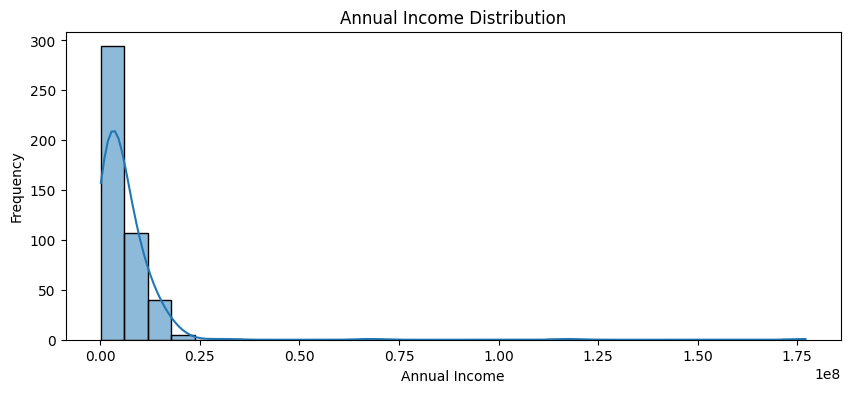

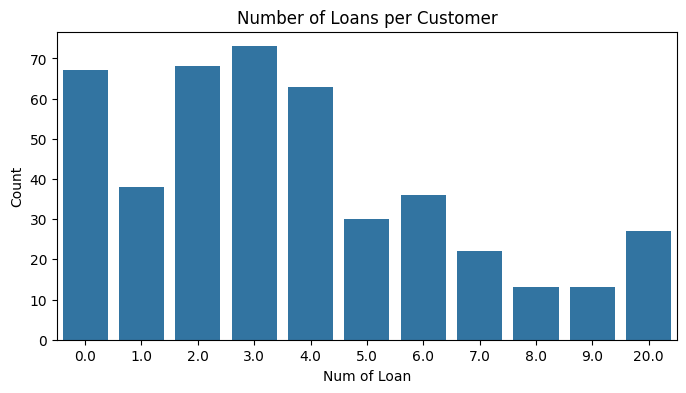

In [14]:
# EDA on financials
financials_path = "datamart/silver/financials/silver_financials_2023_01_01.parquet"
financials_df = spark.read.parquet(financials_path).toPandas()

plot_df = financials_df[["Annual_Income", "Num_of_Loan"]].dropna()

# annual income distribution
plt.figure(figsize=(10, 4))
sns.histplot(plot_df["Annual_Income"], bins=30, kde=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income")
plt.ylabel("Frequency")
plt.show()

# number of loans per customer
plt.figure(figsize=(8, 4))
sns.countplot(x="Num_of_Loan", data=plot_df)
plt.title("Number of Loans per Customer")
plt.xlabel("Num of Loan")
plt.ylabel("Count")
plt.show()

## Gold Level Processing

In [15]:
# create gold datalake
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [16]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_features_gold_table(date_str, silver_base_directory, gold_feature_store_directory, spark)


Processing Gold feature table for 2023-01-01 00:00:00
Files loaded from: DataFrame[Customer_ID: string, Occupation: string, snapshot_date: date, Age: int] with 466 rows
                            DataFrame[fe_1: int, fe_2: int, fe_3: int, fe_4: int, fe_5: int, fe_6: int, fe_7: int, fe_8: int, fe_9: int, fe_10: int, fe_11: int, fe_12: int, fe_13: int, fe_14: int, fe_15: int, fe_16: int, fe_17: int, fe_18: int, fe_19: int, fe_20: int, Customer_ID: string, snapshot_date: date] with 8974 rows
                            DataFrame[Customer_ID: string, Annual_Income: float, Monthly_Inhand_Salary: float, Num_Bank_Accounts: int, Num_Credit_Card: int, Interest_Rate: int, Num_of_Loan: int, Type_of_Loan: string, Delay_from_due_date: int, Num_of_Delayed_Payment: int, Num_Credit_Inquiries: float, Credit_Mix: int, Outstanding_Debt: float, Credit_Utilization_Ratio: float, Payment_of_Min_Amount: int, Total_EMI_per_month: float, Amount_invested_monthly: float, Payment_Behaviour: string, Monthly_Balanc

saved to: datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet
Processing Gold feature table for 2023-02-01 00:00:00
Files loaded from: DataFrame[Customer_ID: string, Occupation: string, snapshot_date: date, Age: int] with 442 rows
                            DataFrame[fe_1: int, fe_2: int, fe_3: int, fe_4: int, fe_5: int, fe_6: int, fe_7: int, fe_8: int, fe_9: int, fe_10: int, fe_11: int, fe_12: int, fe_13: int, fe_14: int, fe_15: int, fe_16: int, fe_17: int, fe_18: int, fe_19: int, fe_20: int, Customer_ID: string, snapshot_date: date] with 8974 rows
                            DataFrame[Customer_ID: string, Annual_Income: float, Monthly_Inhand_Salary: float, Num_Bank_Accounts: int, Num_Credit_Card: int, Interest_Rate: int, Num_of_Loan: int, Type_of_Loan: string, Delay_from_due_date: int, Num_of_Delayed_Payment: int, Num_Credit_Inquiries: float, Credit_Mix: int, Outstanding_Debt: float, Credit_Utilization_Ratio: float, Payment_of_Min_Amount: int, Total_EMI_per_month: floa

## Inspect Feature Store

In [17]:
folder_path = gold_feature_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 104288
+-----------+-------------+--------------------+---------------+------+---------------+--------+-------+--------+-----------+-------+---+-------------------+-----------------+---+----+-------------+--------------------+------------------------+-------------------+-----------------+------------------+--------------------+-----------------+------------------+--------------------+-------------------+-----------------------+---------------------+-----------------+-------------------+---------------------+------------------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+---------------+------------------------+------------------+-------------------+------------------------+--------------------+-------------------+-------------------+------------

In [18]:
df.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- loan_id: string (nullable = true)
 |-- loan_start_date: date (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- installment_num: integer (nullable = true)
 |-- loan_amt: float (nullable = true)
 |-- due_amt: float (nullable = true)
 |-- paid_amt: float (nullable = true)
 |-- overdue_amt: float (nullable = true)
 |-- balance: float (nullable = true)
 |-- mob: integer (nullable = true)
 |-- installments_missed: integer (nullable = true)
 |-- first_missed_date: date (nullable = true)
 |-- dpd: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Has_Valid_Age: integer (nullable = true)
 |-- Occupation_scientist: integer (nullable = true)
 |-- Occupation_media_manager: integer (nullable = true)
 |-- Occupation_musician: integer (nullable = true)
 |-- Occupation_lawyer: integer (nullable = true)
 |-- Occupation_teacher: integer (nullable = true)
 |-- Occupation_developer: